# Mask R-CNN - Inspect Training Data

Inspect and visualize data loading and pre-processing code.

In [1]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import copy
import imgaug

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline

/home/max/venvs/maskrcnn-matterport-1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/max/venvs/maskrcnn-matterport-1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/max/venvs/maskrcnn-matterport-1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/max/venvs/maskrcnn-matterport-1

## Configurations

Run one of the code blocks below to import and load the configurations to use.

In [2]:
# Run one of the code blocks

# Shapes toy dataset
# import shapes
# config = shapes.ShapesConfig()

# MS COCO Dataset

import widerface
config = widerface.CocoConfig()
print(config.GENERATE_MASKS)
WIDERFACE_DIR = "../../datasets/widerface"  # TODO: enter value here

False


## Dataset

In [3]:
# Load dataset
if config.NAME == 'shapes':
    dataset = shapes.ShapesDataset()
    dataset.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
elif config.NAME == "widerface":
    dataset = widerface.CocoDataset(config)
    dataset.load_coco(WIDERFACE_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

class_info: [{'source': '', 'id': 0, 'name': 'BG'}]
loading annotations into memory...
Done (t=0.82s)
creating index...
index created!
Image Count: 12876
Class Count: 2
  0. BG                                                
  1. face                                              


## Display Samples

Load and display images and masks.

In [4]:
image_ids = np.random.choice(dataset.image_ids, 4)
# '''# Load and display random samples
# #segmentation=[] ==> No masks

# for image_id in image_ids:
#     image = dataset.load_image(image_id)
#     mask, class_ids = dataset.load_mask(image_id)
#     visualize.display_top_masks(image, mask, class_ids, dataset.class_names)'''

## Display names of images containing big number of faces

In [5]:
len_annotations=[]
img_name=[]
for i, item in enumerate(dataset.image_info):
    len_annotations.append(len(item['annotations']))
    img_name.append(item['id'])

ind_rmv=[]
exceeding_anns=[]
for i, anns in enumerate(len_annotations):
    if anns>300:
        exceeding_anns.append(anns)
        print(i, anns, img_name[i])
        ind_rmv.append(i)
print('len(exceeding_anns):', len(exceeding_anns))  

44 365 35_Basketball_basketballgame_ball_35_891
61 311 7_Cheering_Cheering_7_548
561 441 7_Cheering_Cheering_7_17
736 458 2_Demonstration_Political_Rally_2_409
991 304 12_Group_Large_Group_12_Group_Large_Group_12_39
1007 305 35_Basketball_basketballgame_ball_35_780
1338 384 2_Demonstration_Demonstration_Or_Protest_2_226
1389 527 37_Soccer_Soccer_37_851
1712 1968 2_Demonstration_Demonstrators_2_371
1799 351 2_Demonstration_Demonstrators_2_559
1941 411 12_Group_Large_Group_12_Group_Large_Group_12_14
2925 343 16_Award_Ceremony_Awards_Ceremony_16_46
3373 883 10_People_Marching_People_Marching_10_People_Marching_People_Marching_10_88
3626 741 12_Group_Large_Group_12_Group_Large_Group_12_261
3904 426 2_Demonstration_Demonstrators_2_40
4304 345 35_Basketball_basketballgame_ball_35_378
4478 1001 47_Matador_Bullfighter_Matador_Bullfighter_47_734
4814 477 35_Basketball_basketballgame_ball_35_1041
5740 1146 47_Matador_Bullfighter_matadorbullfighting_47_376
6474 333 0_Parade_marchingband_1_464
651

## Bounding Boxes

Rather than using bounding box coordinates provided by the source datasets, we compute the bounding boxes from masks instead. This allows us to handle bounding boxes consistently regardless of the source dataset, and it also makes it easier to resize, rotate, or crop images because we simply generate the bounding boxes from the updates masks rather than computing bounding box transformation for each type of image transformation.

8682
../../datasets/widerface/train/JPEGImages/3_Riot_Riot_3_362.jpg
image                    shape: (683, 1024, 3)        min:    0.00000  max:  255.00000  uint8
class_ids                shape: (5,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (5, 4)                min:  252.00000  max:  983.00000  int32
N=5
boxes=[[252 382 283 417]
 [301 700 324 719]
 [300 778 330 802]
 [290 966 312 983]
 [289 476 327 509]]
class_ids=[1 1 1 1 1]


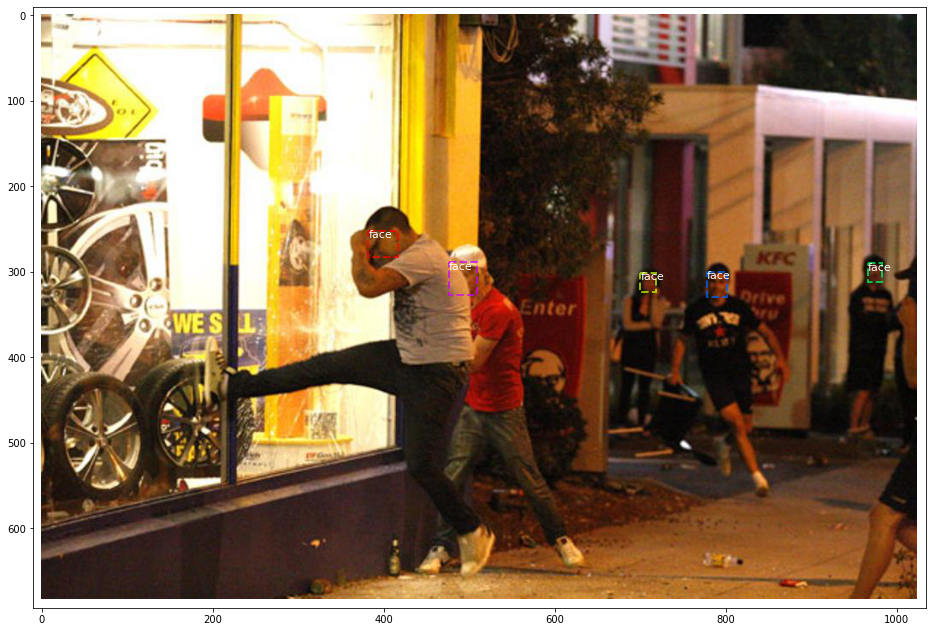

In [6]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)

image = dataset.load_image(image_id)            #(y,x,3) !!!
bbox, class_ids = dataset.load_mask(image_id)

print(image_id)
print(dataset.source_image_link(image_id))

# Display image and additional stats
log("image", image)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances_widerface(image, bbox, class_ids, dataset.class_names)

## Resize Images

To support multiple images per batch, images are resized to one size (1024x1024). Aspect ratio is preserved, though. If an image is not square, then zero padding is added at the top/bottom or right/left.

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
class_ids                shape: (5,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (5, 4)                min:  252.00000  max:  983.00000  int32
N=5
boxes=[[422 382 453 417]
 [471 700 494 719]
 [470 778 500 802]
 [460 966 482 983]
 [459 476 497 509]]
class_ids=[1 1 1 1 1]


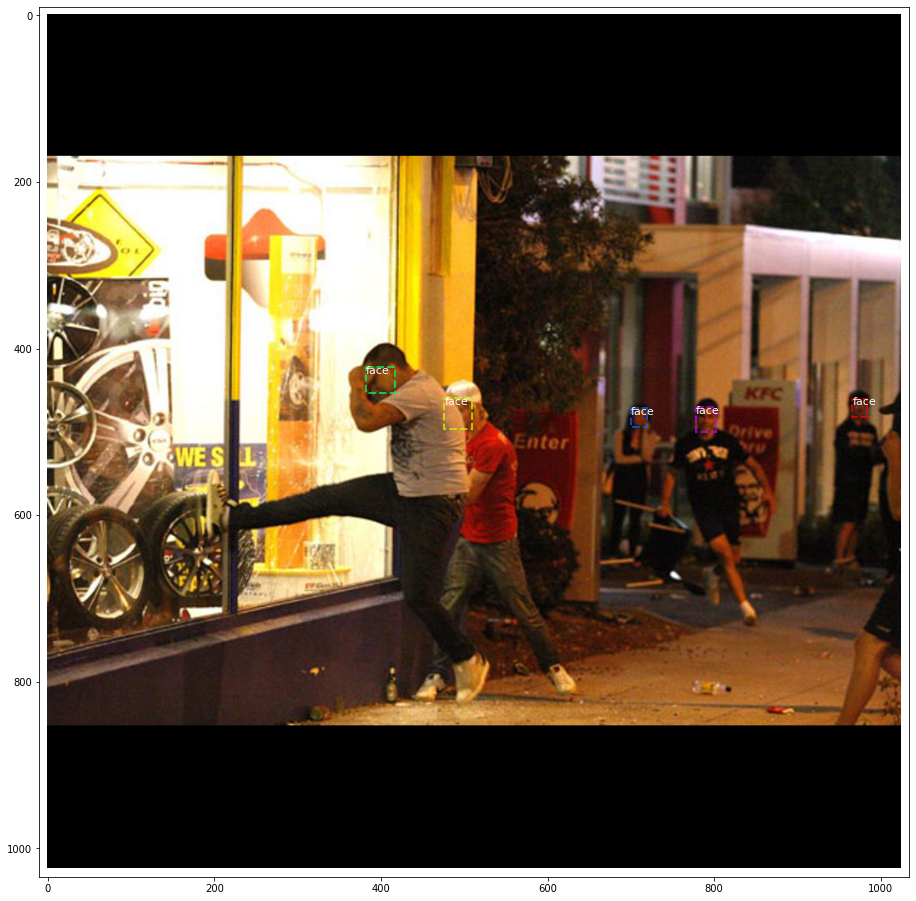

In [7]:
resized=False
if not resized:
    #original_shape = image.shape
    # Resize
    image, window, scale, padding, _, scaled_bbox = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM, 
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE,
        bbox=bbox)
    resized=True
    
log("image", image)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances_widerface(image, scaled_bbox, class_ids, dataset.class_names)


## Augment images

N=5
boxes=[[443 617 481 657]
 [429 313 455 336]
 [411 230 445 260]
 [364  57 389  78]
 [460 518 504 558]]
class_ids=[1 1 1 1 1]


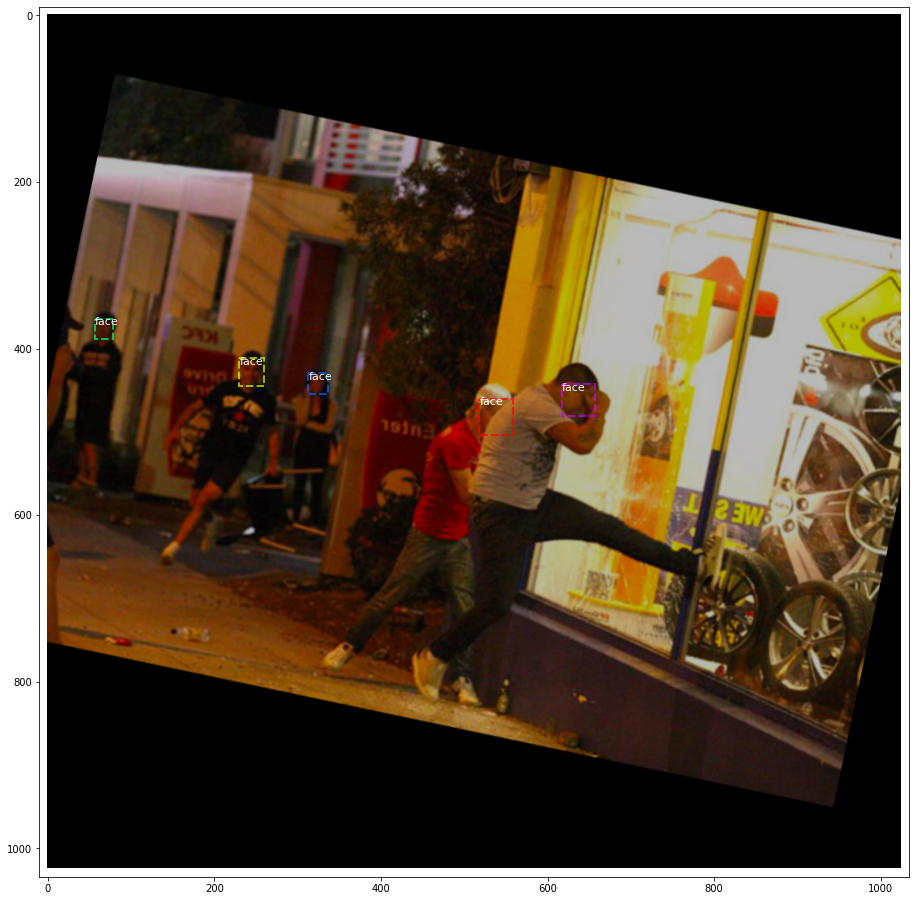

In [8]:
# Add augmentation

image, image_meta, class_ids, bbox = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=False)
visualize.display_instances_widerface(image, bbox, class_ids, dataset.class_names)

## Anchors

The order of anchors is important. Use the same order in training and prediction phases. And it must match the order of the convolution execution.

For an FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts. 
* Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
* Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row. 
* For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.

**Anchor Stride:**
In the FPN architecture, feature maps at the first few layers are high resolution. For example, if the input image is 1024x1024 then the feature map of the first layer is 256x256, which generates about 200K anchors (256x256x3). These anchors are 32x32 pixels and their stride relative to image pixels is 4 pixels, so there is a lot of overlap. We can reduce the load significantly if we generate anchors for every other cell in the feature map. A stride of 2 will cut the number of anchors by 4, for example. 

In this implementation we use an anchor stride of 2, which is different from the paper.

In [9]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  261888
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 196608
Anchors in Level 1: 49152
Anchors in Level 2: 12288
Anchors in Level 3: 3072
Anchors in Level 4: 768


Visualize anchors of one cell at the center of the feature map of a specific level.

Level 0. Anchors: 196608  Feature map Shape: [256 256]
Level 1. Anchors:  49152  Feature map Shape: [128 128]
Level 2. Anchors:  12288  Feature map Shape: [64 64]
Level 3. Anchors:   3072  Feature map Shape: [32 32]
Level 4. Anchors:    768  Feature map Shape: [16 16]


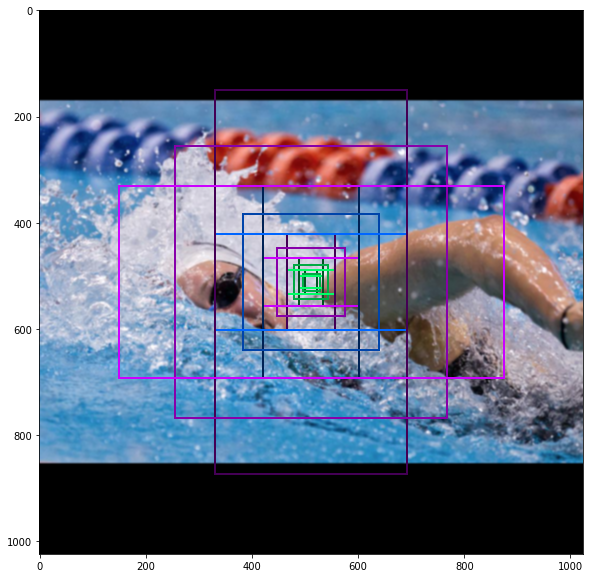

In [10]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _ = modellib.load_image_gt(dataset, config, image_id, augment=True, use_mini_mask=False)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


## Data Generator


In [11]:
# Create data generator
random_rois = 2000
g = modellib.DataGenerator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [12]:
# Uncomment to run the generator through a lot of images
# to catch rare errors
# for i in range(1000):
#     print(i)
#     _, _ = next(g)
#     print(g.data_generator(g.image_ids))

In [13]:
# Get Next Image
gen_img=g.data_generator(g.image_ids)
print(len(gen_img[0]))
if random_rois:
    #[normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, rpn_rois] = gen_img[0]
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox] = gen_img
     
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes] = gen_img[0]
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

8
rois                     shape: (4, 200, 4)           min:    0.00000  max: 1023.00000  int32
mrcnn_class_ids          shape: (4, 200, 1)           min:    0.00000  max:    1.00000  int32
mrcnn_bbox               shape: (4, 200, 2, 4)        min:   -3.32080  max:    3.14304  float32
gt_class_ids             shape: (4, 100)              min:    0.00000  max:    1.00000  int32
gt_boxes                 shape: (4, 100, 4)           min:    0.00000  max: 1014.00000  int32
rpn_match                shape: (4, 261888, 1)        min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 512, 4)           min:   -8.66434  max:    3.75650  float64
image_id:  0 http://cocodataset.org/#explore?id=54_Rescue_firemanrescue_54_436


In [14]:
std_list = []
for i in range(4):
    a = rpn_bbox[:, :, i]
    std_list.append(np.std(a[np.nonzero(a)]))
print(std_list)

[1.5509842841598003, 1.8174845410507683, 2.378174522082191, 2.575155831190789]


anchors                  shape: (261888, 4)           min: -362.03867  max: 1322.03867  float64
refined_anchors          shape: (4, 4)                min:  194.00000  max:  540.00000  float32
Positive anchors: 4
Negative anchors: 508
Neutral anchors: 261376


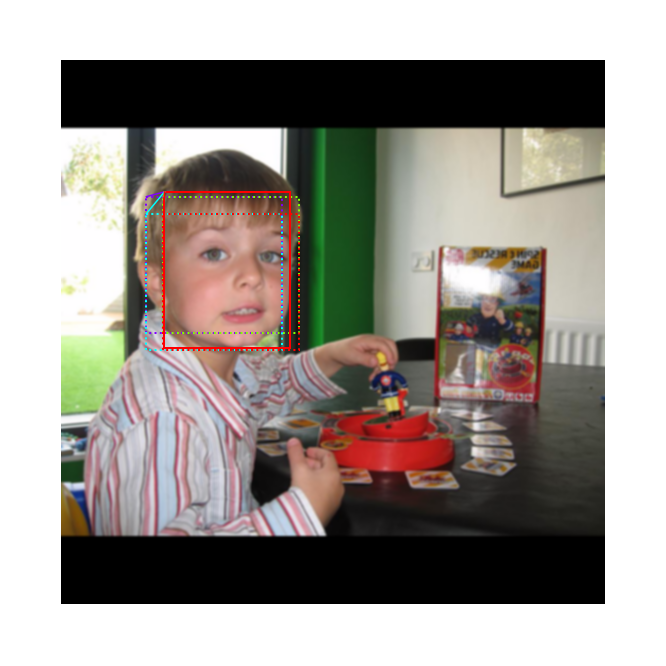

In [15]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# '''# ROI breakdown by class
# for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
#     if n:
#         print("{:23}: {}".format(c[:20], n))'''

# Show positive anchors
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors)

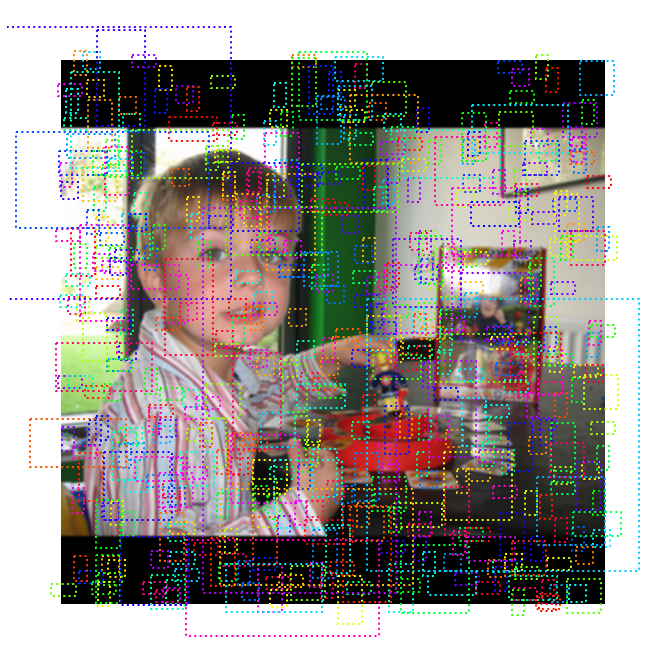

In [16]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

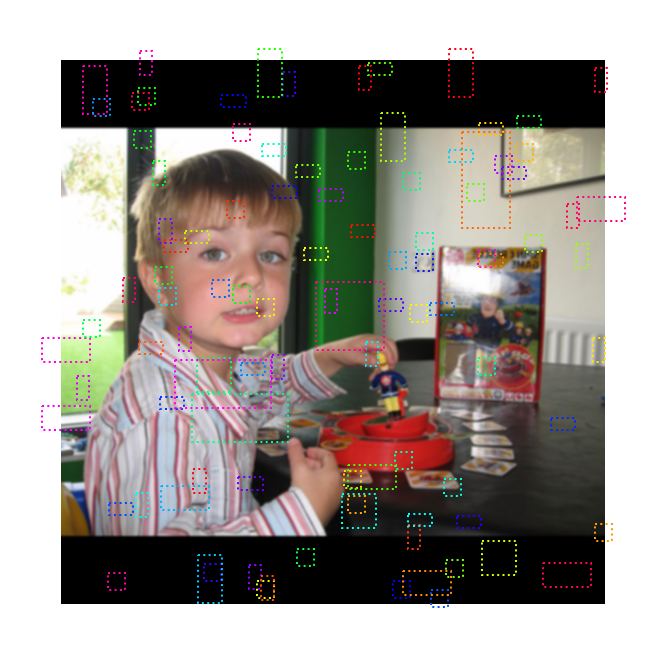

In [17]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## ROIs

Positive ROIs:  27
Negative ROIs:  173
Positive Ratio: 0.14
Unique ROIs: 200 out of 200


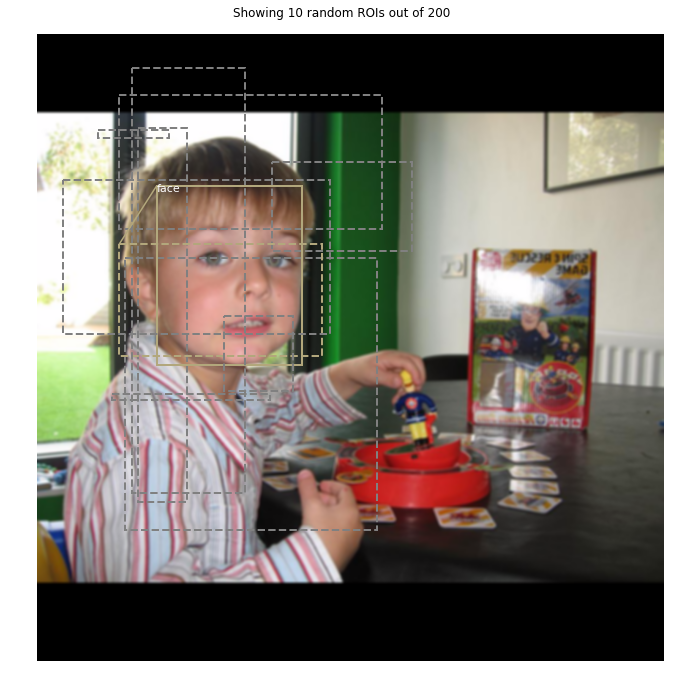

In [18]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]
    
    boxes=rois[b].astype(np.float32)
    deltas=bbox_specific[:,:4] * config.BBOX_STD_DEV
    height = boxes[:, 2] - boxes[:, 0]
         
    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    visualize.draw_rois(sample_image, rois[b], refined_rois, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

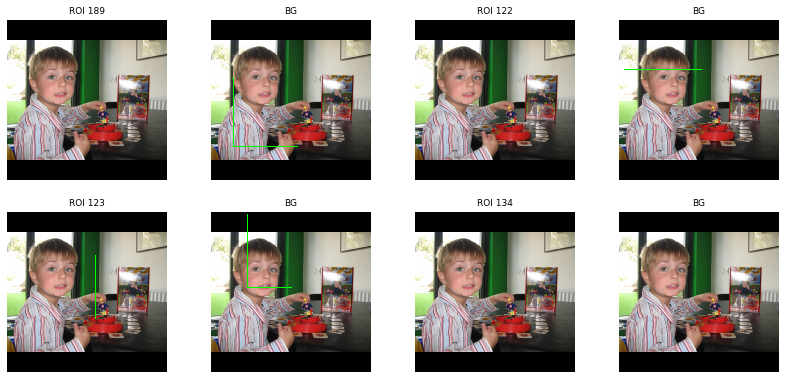

In [19]:
if random_rois:
    # Dispalay ROIs and corresponding bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [20]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.DataGenerator(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        #_, [ids, _, _] = next(temp_g)
        _, [ids, _] = temp_g.data_generator(image_ids)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
Average percent: 0.33
